We fit a gaussian mixture model with a fixed number of clusters; we then estimate for each cluster the kerneldensity and compare it with the kerneldensity at the same point in a randomized dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
import glob

import pylab as plt
from matplotlib.pyplot import get_cmap
%matplotlib inline  

src_dir = os.path.abspath(os.path.join(os.pardir,'src'))
sys.path[0] = src_dir

from analysis.cluster_density import gmm_kd
from analysis.data_sample import get_subset
from analysis.density import rho_pval,rho_eff

# Load data and setup

In [2]:
# factor scores
path_read = os.path.join(src_dir,os.pardir,'data_filter')
fname_read = 'ipip300-no0_arr_pd_neoac_score-1.npy'
filename = os.path.join(path_read,fname_read)
arr_pd =  np.load(filename)

# parameters for fitting
n_rep = 10 # number of different initial conditions for optimization
Nc = 13 # this is the number we found in the paper
n_rep_kd = 1000 # number of randomizations for estaimting density 
bw = -1 # bandwidth for density estimation (-1, estimate from avg nearest-neighbor distance)
N_samples = 10000 # number of pairs of n.n. for estimating bandwidth 


In [3]:
#####
# z-score the data in each dimension
#####
N_,D_ = np.shape(arr_pd)
for d in range(D_):
    x_tmp = arr_pd[:,d]
    x_mu = np.mean(x_tmp)
    x_std = np.std(x_tmp)
    arr_pd[:,d] = (x_tmp - x_mu)/x_std

#####
# get a random subset to reduce processing time
# use line above if you want to fit the whole dataset
#####
arr_x = 1.0*arr_pd#
# arr_x = get_subset(arr_pd,10000) 


# Fit

In [4]:
## fit the gmm
dict_result = gmm_kd(Nc,arr_x,n_rep,n_rep_kd, bw = bw, N_samples = N_samples)

In [5]:

## the cluster centers
arr_cd = dict_result['cluster']




arr_rho = dict_result['rho'] ## density for each cluster in original dataset
arr_rho_rand = dict_result['rho_rand'] ## density for each cluster in randomized dataset

## the p-value and the enrichment for the kerneldensity 
## in comparison to kd in randomimzed datat
arr_rho_eff = rho_eff(arr_rho,arr_rho_rand)
arr_rho_pval = rho_pval(arr_rho,arr_rho_rand)

In [6]:
for i_Nc in range(Nc):
    print('Cluster %s '%(i_Nc+1))
    print('N:%.2f | E:%.2f | O:%.2f | A:%.2f | C:%.2f'%
          (arr_cd[i_Nc,0],arr_cd[i_Nc,1],arr_cd[i_Nc,2],arr_cd[i_Nc,3],arr_cd[i_Nc,4]) )
    print('p-value:%.2f | enrichment:%.2f'%
          (arr_rho_pval[i_Nc],arr_rho_eff[i_Nc]))
    print('---')

Cluster 1 
N:-0.41 | E:-0.58 | O:-0.03 | A:-1.72 | C:0.60
p-value:1.00 | enrichment:0.74
---
Cluster 2 
N:-0.83 | E:0.47 | O:0.41 | A:0.28 | C:0.71
p-value:0.00 | enrichment:1.42
---
Cluster 3 
N:0.84 | E:-0.31 | O:-0.56 | A:-0.08 | C:0.94
p-value:0.56 | enrichment:0.99
---
Cluster 4 
N:0.13 | E:0.45 | O:-0.43 | A:0.64 | C:0.35
p-value:0.00 | enrichment:1.50
---
Cluster 5 
N:0.79 | E:-0.84 | O:0.37 | A:0.77 | C:-0.67
p-value:0.10 | enrichment:1.09
---
Cluster 6 
N:0.32 | E:0.15 | O:0.87 | A:-1.11 | C:-0.63
p-value:0.97 | enrichment:0.88
---
Cluster 7 
N:0.31 | E:-0.63 | O:0.91 | A:0.24 | C:0.51
p-value:1.00 | enrichment:0.87
---
Cluster 8 
N:0.80 | E:-0.52 | O:-0.85 | A:-0.12 | C:-0.65
p-value:0.03 | enrichment:1.12
---
Cluster 9 
N:-0.93 | E:-1.07 | O:0.29 | A:-0.08 | C:-0.56
p-value:0.94 | enrichment:0.91
---
Cluster 10 
N:-0.50 | E:0.53 | O:0.57 | A:0.49 | C:-0.70
p-value:0.68 | enrichment:0.98
---
Cluster 11 
N:-0.62 | E:-0.19 | O:-0.77 | A:0.17 | C:0.24
p-value:0.00 | enrichment:1

# Plot the result

for each cluster we plot the p-value and the enrichment

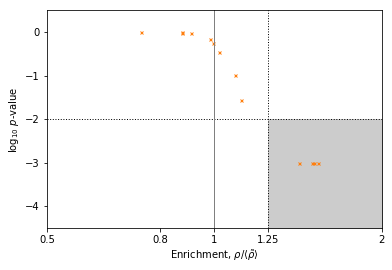

In [8]:
pval_crit = 0.01
eff_crit = 1.25
cmap = get_cmap('tab10')
c_ = cmap(1)
c_shade=str(0.8)
cmap = get_cmap('tab10')


f = plt.figure()

ax = f.add_subplot(111)
x = np.log10(arr_rho_eff + 0.0*np.random.random(size=len(arr_rho_eff))   ) 
y = np.log10(arr_rho_pval)
ax.plot(x,y,ms=3,lw=0,marker='x',color=c_)
# ax.fill_between(x,0.001+0.0*x,1.0+0.0*x,where=y<=pval_crit,color=c_shade)
# ax.set_yscale('log')

#     xmin = 0.
xmax = np.log10(2.)
xmin=-xmax

ymin = -4.5
ymax=0.5
x = np.linspace(xmin,xmax,10)
y = np.log10(pval_crit)+0.0*x
ax.plot(x,y,ms=0,lw=1,ls=':',marker='o',color='black')

x = [np.log10(eff_crit),np.log10(eff_crit)]
y = [ymin,ymax]
ax.plot(x,y,ms=0,lw=1,ls=':',marker='o',color='black')

x = [0,0]
y = [ymin,ymax]
ax.plot(x,y,ms=0,lw=1,ls='-',marker='o',color=str(0.5))#,alpha=0.5)

x = np.linspace(np.log10(eff_crit),xmax,10)
y1 = ymin + 0.0*x
y2 = np.log10(pval_crit) + 0.0*x
ax.fill_between(x,y1,y2,color=c_shade)

# # ax.set_xlabel(r'cluster index')
ax.set_ylabel(r'$\log_{10}$ $p$-value')
# ax.set_yscale('log')

x_marks = np.log10( np.array([0.5,0.8, 1., 1.25,2.]) )
x_labels = ['0.5','0.8','1','1.25','2']
ax.set_xticks(x_marks)
ax.set_xticklabels(x_labels)
# ax.set_xticklabels([])
ax.set_yticks([-4,-3,-2,-1,0])
# ax.set_yticklabels([r'$-3$',r'$-2$',r'$-1$',r'$0$'])
ax.set_ylim(-4.5,0.5)
ax.set_xlim(xmin,xmax)



#     ax.locator_params(axis = 'x',nbins=5)
ax.set_xlabel(r'Enrichment, $\rho/\langle \tilde{\rho} \rangle$',labelpad=3)
